### Setup packages 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%pip install progressbar
%pip install plotnine
%pip install torch
%pip install ipython-autotime
%load_ext autotime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
time: 465 µs (started: 2022-07-06 15:33:10 +00:00)


In [2]:
from plotnine import *
from plotnine.themes import *

time: 1.22 s (started: 2022-07-06 15:33:10 +00:00)


In [3]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
# import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tqdm import tqdm

time: 1.19 s (started: 2022-07-06 15:33:11 +00:00)


_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [4]:
paper_name = "dgm_hestoncurriculum"

time: 349 µs (started: 2022-07-06 15:33:12 +00:00)


In [5]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

# make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
# make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
# make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
# make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
# make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
# make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
# make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
# make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
# make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
# make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")

time: 5.7 ms (started: 2022-07-06 15:33:12 +00:00)


In [6]:
# Set up the imports
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

import torch
from torch.distributions import Normal
import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


time: 630 ms (started: 2022-07-06 15:33:12 +00:00)


In [7]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from matplotlib import cm
import pdb
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

time: 857 µs (started: 2022-07-06 15:33:13 +00:00)


In [8]:
import plotly.graph_objects as go
import plotly.express as px


time: 686 ms (started: 2022-07-06 15:33:13 +00:00)


### Shared functions across models

In [9]:
import pandas as pd

def plot_report(train_instance):
        
    history_tl_cpu = [ x for x in train_instance.history_tl ]
    history_internal_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_internal_cpu ]
    history_terminal_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_terminal ]
    history_initial_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_initial ]

    obs_data = pd.DataFrame({"Epochs" : [ (x+1)*train_instance.hook_interval for x in range(len(history_initial_cpu))], 
                             "AvgLogLoss": np.log(history_tl_cpu), 
                             "TerminalLogLoss" :  np.log(history_terminal_cpu),
                             "InternalLogLoss" :  np.log(history_internal_cpu),
                             "InitialLogLoss" : np.log(history_initial_cpu)
                             })

    return (ggplot(obs_data, aes("Epochs","AvgLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","TerminalLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","InternalLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","InitialLogLoss")) + geom_line() + geom_point())

def plot_activation_mean(train_instance):
    
    if train_instance.debug == False:
        print( 'error: debug is off , turn it on and train again ' )
    else:
        history = np.array(train_instance.history_mean_hooks)
        jet= plt.get_cmap('jet')
        colors = iter(jet(np.linspace(0,1,10)))
        fig, ax = plt.subplots()
        for i in range(history.shape[1]):
            ax.plot(history[:,i], '--r', label= i , color=next(colors) )
        fig.suptitle('Layers activation mean value', fontsize=10)
        leg = ax.legend();


time: 2.15 ms (started: 2022-07-06 15:33:13 +00:00)


In [10]:
# a set up that just maximizes the loss s.t. loss < eps (maximizeloss_weights_st) using the weights on the losses
from scipy.optimize import LinearConstraint, NonlinearConstraint
from scipy.optimize import Bounds
from functools import partial
from scipy.optimize import minimize
from functools import wraps

def negative(f):
    @wraps(f)
    def g(*args,**kwargs):
        return - f(*args,**kwargs)
    # g.__name__ = f'negative({f.__name__})'
    return g
# kl_loss = nn.KLDivLoss(size_average=None, reduction="batchmean")

# we can add more minimization functions here later (e.g. SS diff)
def KLDiffHere( varX, loss_terms, log_target = False, reduction = "mean"):  
  target = torch.tensor([1./len(loss_terms)]*len(loss_terms))*torch.tensor(loss_terms)
  input = torch.tensor(varX*loss_terms)
  loss_pointwise = target * (torch.log(target) - torch.log(input))
  if reduction == "mean":  # default
      loss = loss_pointwise.mean()
  elif reduction == "batchmean":  # mathematically correct
      loss = loss_pointwise.sum() / input.size(0)
  elif reduction == "sum":
      loss = loss_pointwise.sum()
  else:  # reduction == "none"
      loss = loss_pointwise  
  return loss

  # return torch.nn.KLDivLoss(varX*loss_terms,np.array([1./len(loss_terms)]*len(loss_terms))*loss_terms)

def minimize_weights_st(loss_terms, loss_func):
  bounds = Bounds([0]*len(loss_terms), [1.0]*len(loss_terms))
  linear_constraint = LinearConstraint([[1]*len(loss_terms)], [1.0], [1.0])
  x0 = [0.25]*len(loss_terms)
  res = minimize( partial(loss_func, loss_terms=loss_terms), 
                  x0, 
                  method='trust-constr', 
                  constraints=[linear_constraint],
                  options={'verbose': 0}, 
                  bounds=bounds )
  return res

def maximizeloss_weights_st(loss_terms, loss_func, eps):
  bounds = Bounds([0]*len(loss_terms), [1.0]*len(loss_terms))
  linear_constraint = LinearConstraint([[1]*len(loss_terms)], [1.0], [1.0])
  nonlinear_constraint  = NonlinearConstraint(negative(partial(loss_func, loss_terms=loss_terms)),1E-9,eps)
  # even though zero is the KL minimum it helps to put a negative number here to explore

  x0 = [1.0/len(loss_terms)]*len(loss_terms)
  res = minimize( negative(partial(loss_func, loss_terms=loss_terms)), 
                  x0, 
                  method='trust-constr', 
                  constraints=[linear_constraint, nonlinear_constraint],
                  options={'verbose': 0}, 
                  bounds=bounds )
  return res


time: 4.26 ms (started: 2022-07-06 15:33:13 +00:00)


In [11]:
r1 = maximizeloss_weights_st( [ 34.25, 100.12, 23.45] , KLDiffHere, 1E9)
print(r1.x)

[0.33334757 0.33333761 0.33331482]
time: 43.7 ms (started: 2022-07-06 15:33:13 +00:00)


In [12]:
loss_terms= [ 34.25, 100.12, 23.45]
torch.tensor([1./len(loss_terms)]*len(loss_terms))*torch.tensor(loss_terms)

tensor([11.4167, 33.3733,  7.8167])

time: 9.79 ms (started: 2022-07-06 15:33:13 +00:00)


In [13]:


std_norm_cdf = Normal(0, 1).cdf
std_norm_pdf = lambda x: torch.exp(Normal(0, 1).log_prob(x))

def bs_price(right, K, S, T, sigma, r):
    d_1 = (1 / (sigma * torch.sqrt(T))) * (torch.log(S / K) + (r + (torch.square(sigma) / 2)) * T)
    d_2 = d_1 - sigma * torch.sqrt(T)
    
    if right == "C":
        C = std_norm_cdf(d_1) * S - std_norm_cdf(d_2) * K * torch.exp(-r * T)
        return C
    elif right == "P":
        P = std_norm_cdf(-d_2) * K * torch.exp(-r * T) - std_norm_cdf(-d_1) * S
        return P
      
def bs_delta(right, K, S, T, sigma, r):
    d_1 = (1 / (sigma * torch.sqrt(T))) * (torch.log(S / K) + (r + (torch.square(sigma) / 2)) * T)
    if right == "C":
        return std_norm_cdf(d_1) 
    elif right == "P":
        return std_norm_cdf(d_1) - 1.0

def bs_gamma(K, S, T, sigma, r):
    d_1 = (1 / (sigma * torch.sqrt(T))) * (torch.log(S / K) + (r + (torch.square(sigma) / 2)) * T)
    return std_norm_pdf(d_1)/(S*sigma*torch.sqrt(T)) 

def bs_theta(right, K, S, T, sigma, r):
    d_1 = (1 / (sigma * torch.sqrt(T))) * (torch.log(S / K) + (r + (torch.square(sigma) / 2)) * T)
    d_2 = d_1 - sigma * torch.sqrt(T)
    if right == "C":
        theta_call = (-S*std_norm_pdf(d_1)*sigma)/(2*torch.sqrt(T))-r*K*torch.exp(-r*T)*std_norm_cdf(d_2)
        return theta_call 
    elif right == "P":
        theta_put = (-S*std_norm_pdf(d_1)*sigma)/(2*torch.sqrt(T))+r*K*torch.exp(-r*T)*std_norm_cdf(-d_2)
        return std_norm_cdf(d_1) - 1.0        


time: 2.95 ms (started: 2022-07-06 15:33:14 +00:00)


In [14]:
def to_cpu_detach(x):
  if isinstance(x, list):
    return [ y.detach().cpu().item() for y in x ]
  else:
    return x.detach().cpu().item()

time: 3.73 ms (started: 2022-07-06 15:33:14 +00:00)


In [15]:
def huber_loss_zero_target(x, delta = 1.0):
  loss_function = torch.nn.HuberLoss(delta=delta)
  return loss_function(x, torch.zeros_like(x))


time: 503 µs (started: 2022-07-06 15:33:16 +00:00)


In [16]:
def save_model_train(lr, net,  eqLossFn, sample_method, trainObj, eqType, eqObject = None ):

  model_id_str =  f"{eqType}_{datetime.datetime.now():%Y%m%d%H%M%S}_{eqLossFn}_{sample_method}_{trainObj.stop_epoch}_{str(lr).replace('.','p')}_{net.NL}_{net.NN}"
  
  if eqObject is not None:
    try:
        beta = getattr(eqObject,"beta")
        beta_str = str(beta).replace('.','p')
        model_id_str = model_id_str + f"_beta{beta_str}"
    except AttributeError:
        pass
    try:
        gamma = getattr(eqObject,"gamma")
        gamma_str = str(gamma).replace('.','p')
        model_id_str = model_id_str + f"_gamma{gamma_str}"
    except AttributeError:
        pass
  
  torch.save(net.state_dict(), f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{model_id_str}")
  df_at_hookintervals = None
  train_losses = None
  validation_losses = None
  try:
      df_at_hookintervals = getattr(trainObj, "history_surfaces_hooks")
      if df_at_hookintervals is not None:
        df_at_hookintervals.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationHook_{trainObj.hook_interval}_{model_id_str}.csv", index=False)
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "history_surfaces_hooks"))

  try:
      train_losses = getattr(trainObj,"train_losses")
      if train_losses is not None:
        train_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/trainlosses_{model_id_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))
      # raise NotImplementedError("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))

  try:
      validation_losses = getattr(trainObj,"validation_losses")
      if validation_losses is not None:
        validation_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationlosses_{model_id_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "validation_losses"))

time: 2.43 ms (started: 2022-07-06 15:33:17 +00:00)


In [17]:
def save_model_train_stratified(lr, net,  eqLossFn, sample_method, trainObj, eqType, eqObject = None ):

  model_id_str =  f"{eqType}_{datetime.datetime.now():%Y%m%d%H%M%S}_{eqLossFn}_{sample_method}_{trainObj.stop_epoch}_{str(lr).replace('.','p')}_{net.NL}_{net.NN}"
  
  if eqObject is not None:
    try:
        beta = getattr(eqObject,"beta")
        beta_str = str(beta).replace('.','p')
        model_id_str = model_id_str + f"_beta{beta_str}"
    except AttributeError:
        pass
    try:
        gamma = getattr(eqObject,"gamma")
        gamma_str = str(gamma).replace('.','p')
        model_id_str = model_id_str + f"_gamma{gamma_str}"
    except AttributeError:
        pass
    try:
        xbreaks = getattr(eqObject,"xbreaks")
        xbreaks_str = str(len(xbreaks))
        model_id_str = model_id_str + f"_StSaXbrks{xbreaks_str}"
    except AttributeError:
        pass
    try:
        tbreaks = getattr(eqObject,"tbreaks")
        tbreaks_str = str(len(tbreaks))
        model_id_str = model_id_str + f"_StSaTbrks{tbreaks_str}"
    except AttributeError:
        pass
  
  torch.save(net.state_dict(), f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{model_id_str}")
  df_at_hookintervals = None
  train_losses = None
  validation_losses = None
  try:
      df_at_hookintervals = getattr(trainObj, "history_surfaces_hooks")
      if df_at_hookintervals is not None:
        df_at_hookintervals.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationHook_{trainObj.hook_interval}_{model_id_str}.csv", index=False)
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "history_surfaces_hooks"))

  try:
      train_losses = getattr(trainObj,"train_losses")
      if train_losses is not None:
        train_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/trainlosses_{model_id_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))
      # raise NotImplementedError("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))

  try:
      validation_losses = getattr(trainObj,"validation_losses")
      if validation_losses is not None:
        validation_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationlosses_{model_id_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "validation_losses"))

time: 2.62 ms (started: 2022-07-06 15:33:18 +00:00)


### Heston options - sampling methodology


[Heston Model in terms of log price (not used)](https://www.frouah.com/finance%20notes/The%20Heston%20model%20short%20version.pdf)


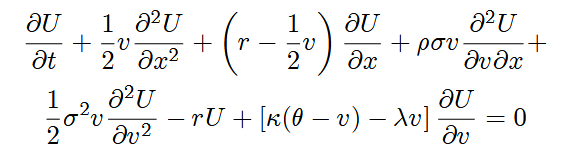



[Heston Model in terms of price ](https://www.frouah.com/finance%20notes/The%20Heston%20model%20short%20version.pdf)

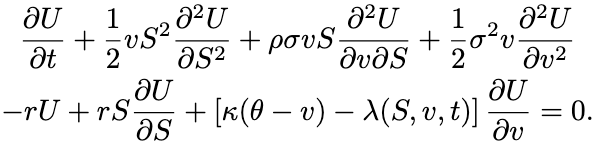


#### HestonOptionNet

In [88]:
class HestonOptionNet(nn.Module):
    def __init__(self , NL  , NN, activation = torch.tanh):
        super(HestonOptionNet, self).__init__()
        self.NL = NL
        self.NN = NN
        ### time, nu (vol), log of the stock Px
        ### ( t , xi)
        self.Input = 12
        self.fc_input = nn.Linear(self.Input,self.NN)
        #self.batch_input = nn.BatchNorm1d(self.NN)
        torch.nn.init.xavier_uniform_(self.fc_input.weight)
        self.linears = nn.ModuleList([nn.Linear(self.NN, self.NN) for i in range(self.NL)])
        #self.batchs = nn.ModuleList([nn.BatchNorm1d(self.NN) for i in range(self.NL)]) 

        for i, l in enumerate(self.linears):    
            torch.nn.init.xavier_uniform_(l.weight)
        self.fc_output = nn.Linear(self.NN, 1)
        torch.nn.init.xavier_uniform_(self.fc_output.weight)
        self.act = activation
        
    def forward(self, x):
        h = self.act( (self.fc_input(x))  )
        for i, l in enumerate(self.linears):
            h = self.act( l(h) )
        out = self.fc_output(h)
        return torch.nn.functional.softplus(out)
    

time: 1.28 ms (started: 2022-07-06 18:02:32 +00:00)


#### AlternativeNet

[implement from github](https://github.com/Plemeur/DGM/blob/master/first_net.py)

In [19]:
class LinearWithXavier(nn.Module):
    """ Copy of linear module from Pytorch, modified to have a Xavier init,
        TODO : figure out what to do with the bias"""
    def __init__(self, in_features, out_features, bias=True, batch_normalize=False):
        super(LinearWithXavier, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.batch_normalize = batch_normalize
        
        if self.batch_normalize == True:
          self.batch_norm = torch.nn.BatchNorm1d(out_features)
        
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            torch.nn.init.uniform_(self.bias, -1, 1) #boundary matter?
    
    def forward(self, input):
        if self.batch_normalize == True:
          return self.batch_norm(torch.nn.functional.linear(input, self.weight, self.bias))
        return torch.nn.functional.linear(input, self.weight, self.bias)
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


class DGM_layer(nn.Module):
    """ See readme for paper source"""
    def __init__(self, in_features, out_feature, residual=False, batch_normalize=False):
        super(DGM_layer, self).__init__()
        self.residual = residual

        self.Z = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UZ = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)
        self.G = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UG = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)
        self.R = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UR = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)
        self.H = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UH = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)

    def forward(self, x, s):
        z = torch.tanh(self.UZ(x) + self.Z(s))
        g = torch.tanh(self.UG(x) + self.G(s))
        r = torch.tanh(self.UR(x) + self.R(s))
        h = torch.tanh(self.UH(x) + self.H(s * r))
        return (1 - g) * h + z * s


class AlternativeNet(nn.Module):

    def __init__(self, in_size, out_size, neurons, depth):
        super(AlternativeNet, self).__init__()
        self.dim = in_size
        self.input_layer = LinearWithXavier(in_size, neurons)
        self.middle_layer = nn.ModuleList([DGM_layer(in_size, neurons) for i in range(depth)])
        # self.middle_layer_2 = nn.ModuleList([DGM_layer(in_size, neurons, batch_normalize=False) for i in range(2)])
        self.final_layer = LinearWithXavier(neurons, out_size, batch_normalize=False)
        
    def forward(self, X):
        s = torch.tanh(self.input_layer(X))
        for i, layer in enumerate(self.middle_layer):
            s = torch.tanh(layer(X, s))
        
        # for i, layer in enumerate(self.middle_layer_2):
        #     s = torch.tanh(layer(X, s))
        
        # s = torch.nn.functional.gelu(self.input_layer(X))
        # for i, layer in enumerate(self.middle_layer):
        #     s = torch.nn.functional.elu(layer(X, s))
        # for i, layer in enumerate(self.middle_layer):
        #     s = torch.nn.functional.gelu(layer(X, s))
        # for i, layer in enumerate(self.middle_layer_2):
        #     s = torch.nn.functional.gelu(layer(X, s))

        return torch.nn.functional.softplus(self.final_layer(s))
        # return torch.pow(self.final_layer(s), 1)


time: 3.49 ms (started: 2022-07-06 15:33:22 +00:00)


0.0625

time: 8.28 ms (started: 2022-07-05 11:39:15 +00:00)


#### EuropeanHestonSingleStockCurriculum

In [84]:
class EuropeanHestonSingleStockCurriculum():
    
    def __init__(self , net, is_call = True):

        self.C = 0.0           
        self.R = 0.05         # Interest Rate (Yearly)

        self.BS_SIGMA = 0.25  # BS Vol of Stock
        self.SIGMA = 0.25     # Vol of Vol (Yearly)
        self.KAPPA = 0.25     # OU reversion coefficient
        self.THETA = 0.0625   # long term mean of Vol of Vol
        self.RHO  = 0.75      # correlation of Vol and S
        self.LAMBDA = 0.      # the price of risk
        
        self.K = 1.0              # Strike Price 
        self.T = 1.0               # Maturation time (in YEAR)
        
        self.MAX_S = self.K*3.0   # MAX price
        self.MAX_NU = 2.0
        self.MAX_VOLVOL = 0.5
        self.MAX_KAPPA = 1
        self.MAX_RHO = 0.8
        self.MAX_THETA = 0.15


        ## for accept reject purpose!
        ## free boundry problems
        self.net = net
        
        self.gamma = 0.0001
        self.beta = 0.0001

        self.is_call = is_call
        self.log_normal_dist = torch.distributions.LogNormal(self.R-self.C, self.BS_SIGMA)
        self.log_normal_dist_5 = torch.distributions.LogNormal(self.R-self.C, self.BS_SIGMA*5.0)

        self.xbreaks = None
        self.tbreaks = None

    def g(self , x):
        # pay off function - 1 is the stock dimension, 0 is the time dimension
        if self.is_call:
          return torch.max( x[:,1].reshape(-1,1) - x[:,2].reshape(-1,1), torch.zeros([len(x),1]).cuda() ) 
        else:
          return torch.max( x[:,2].reshape(-1,1) - x[:,1].reshape(-1,1) , torch.zeros([len(x),1]).cuda() ) 

    def mu(self, x):
        ## should test it! output dimension is important !
        return (self.R-self.C)*x.reshape(-1,1)

    def sigma(self , x):
        return self.BS_SIGMA*x.reshape(-1,1)

    @staticmethod
    def to_device(x, to_cpu):
      if to_cpu:
        return x.cpu()
      else:
        return x.cuda()

    def sample(self , sample_method_X = "U", size = 2**8, to_cpu = False ):
        '''
        Sampling function
        '''
        
        # internal samples
        S_internal_values = (1 - torch.rand([size, 1])) * self.MAX_S
        maturity_time = (1 - torch.rand([size, 1])) * self.T
        t_internal_values = torch.rand([size,1]) * maturity_time
        strike_values = torch.rand([size, 1]) * self.K
        risk_free_rate = torch.rand([size, 1])*self.R
        std_dev_of_stock = (1 - torch.rand([size, 1]))*self.BS_SIGMA
        nu_internal_values = (1 - torch.rand([size, 1])) * self.MAX_NU
        vol_vol_values = (1 - torch.rand([size, 1])) * self.MAX_VOLVOL
        kappa_values = torch.rand([size, 1]) * self.MAX_KAPPA
        rho_values = torch.rand([size, 1]) * self.MAX_RHO
        theta_values = (1 - torch.rand([size, 1])) * self.MAX_THETA
        lamda_values = torch.rand([size, 1]) * self.LAMBDA


        #xvt_internal = self.to_device(torch.cat(( t_internal_values , S_internal_values, strike_values, maturity_time, risk_free_rate, std_dev_of_stock), dim = 1 ), to_cpu)
        xvt_internal = self.to_device(torch.cat(( t_internal_values , S_internal_values, strike_values, maturity_time, risk_free_rate, std_dev_of_stock, nu_internal_values, vol_vol_values, kappa_values, rho_values, theta_values, lamda_values), dim = 1 ), to_cpu)

        ### Terminal time samples
        
        S_terminal_values = (1 - torch.rand([size, 1])) * self.MAX_S
        maturity_time = (1 - torch.rand([size, 1])) * self.T
        t_terminal_values = maturity_time
        strike_values = torch.rand([size, 1]) * self.K
        risk_free_rate = torch.rand([size, 1]) * self.R
        std_dev_of_stock = (1 - torch.rand([size, 1])) * self.BS_SIGMA
        nu_terminal_values = (1 - torch.rand([size, 1])) * self.MAX_NU
        vol_vol_values = (1 - torch.rand([size, 1])) * self.MAX_VOLVOL
        kappa_values = torch.rand([size, 1]) * self.MAX_KAPPA
        rho_values = torch.rand([size, 1]) * self.MAX_RHO
        theta_values = (1 - torch.rand([size, 1])) * self.MAX_THETA
        lamda_values = torch.rand([size, 1]) * self.LAMBDA


        #xvt_terminal = self.to_device(torch.cat(( t_terminal_values , S_terminal_values, strike_values, maturity_time, risk_free_rate, std_dev_of_stock) , dim = 1 ),to_cpu)
        xvt_terminal = self.to_device(torch.cat(( t_terminal_values , S_terminal_values, strike_values, maturity_time, risk_free_rate, std_dev_of_stock, nu_terminal_values, vol_vol_values, kappa_values, rho_values, theta_values, lamda_values) , dim = 1 ),to_cpu)



        return xvt_internal , xvt_terminal 

        
    def criterion(self, x_internal , x_terminal , loss_transforms = [torch.square], print_val=False, to_cpu=False, supervised_data=None):
        '''
        Loss function that helps network find solution to equation
        '''   
        
        pred_values = self.net(x_internal)
        d = torch.autograd.grad(
            pred_values,
            x_internal, 
            grad_outputs=torch.ones_like(pred_values) ,
            create_graph=True )
        dt  = d[0][:,0].reshape(-1,1)
        dS1 = d[0][:,1].reshape(-1,1)
        dK = d[0][:,2].reshape(-1,1)
        dT = d[0][:,3].reshape(-1,1)
        dv1 = d[0][:, 6].reshape(-1, 1)

        # d2u/dSdS
        dS1S1 = torch.autograd.grad(dS1, 
                                    x_internal, 
                                    grad_outputs=torch.ones_like(dS1),
                                    create_graph = True)[0][:,1].reshape(-1,1)


        # d2u/dvdv
        dv1v1 = torch.autograd.grad(dv1, 
                                    x_internal, 
                                    grad_outputs=torch.ones_like(dv1),
                                    create_graph = True, allow_unused=True)[0][:,6].reshape(-1,1)

        # d2u/dxdv
        dS1v1 = torch.autograd.grad(dS1, 
                                    x_internal, 
                                    grad_outputs=torch.ones_like(dS1),
                                    create_graph = True, allow_unused=True)[0][:,6].reshape(-1,1)

        dK1dK1 = torch.autograd.grad(dK, 
                                   x_internal, 
                                   grad_outputs=torch.ones_like(dK),
                                   create_graph = True, allow_unused=True)[0][:,2].reshape(-1,1)
                            
        #print(dx1v1)

        
        if loss_transforms is None:
          loss_transforms = [torch.square]
        intC = None
        terC = None

        if len(x_internal) == 0:
          intC = [ torch.tensor(0).cuda().float() for loss_transform in loss_transforms ] 
        else:
          # pdb.set_trace()
          # x is above the free boundary ( so immediate pay-off is positive )
          # t_internal_values , nu_internal_values, x_internal_values, strike_values, maturity_time, risk_free_rate, std_dev_of_stock
          time_elapsed = x_internal[:,0].reshape(-1, 1)
          stock_price = x_internal[:,1].reshape(-1, 1)
          strike_price = x_internal[:,2].reshape(-1, 1)
          maturity_years = x_internal[:, 3].reshape(-1, 1)
          risk_free_rate = x_internal[:, 4].reshape(-1, 1)
          std_dev_of_stock = x_internal[:, 5].reshape(-1, 1)
          nu_of_stock = x_internal[:, 6].reshape(-1, 1)
          vol_of_vol_stock = x_internal[:, 7].reshape(-1, 1)
          kappa_values = x_internal[:, 8].reshape(-1, 1)
          rho_values = x_internal[:, 9].reshape(-1, 1)
          theta_values =  x_internal[:, 10].reshape(-1, 1)
          lamda_values =  x_internal[:, 11].reshape(-1, 1)
          
          #std_dev_of_stock = self.BS_SIGMA
          #risk_free_rate = self.R

          time_to_maturity = maturity_years - time_elapsed

          bs_gammas = bs_gamma( strike_price, 
                                 stock_price, 
                                 time_to_maturity,
                                 theta_values ** 0.5,   # need to validate this                               
                                 risk_free_rate)

          #intC_loss_untransformed = dt + 0.5*(std_dev_of_stock**2)*(stock_price**2)*dS1S1 - \
          #                          risk_free_rate*pred_values + \
          #                          risk_free_rate*stock_price*dS1
          
          intC_loss_untransformed = dt + 0.5 * nu_of_stock * stock_price**2 * dS1S1 + \
                                    rho_values * vol_of_vol_stock * nu_of_stock * stock_price * dS1v1 + \
                                    0.5 * vol_of_vol_stock**2 * nu_of_stock * dv1v1 - \
                                    risk_free_rate * pred_values + \
                                    risk_free_rate * stock_price * dS1 + \
                                    ( kappa_values * (theta_values - nu_of_stock) - lamda_values* nu_of_stock ) * dv1 #+\
                                    #0.5 * (nu_of_stock - theta_values) * stock_price**2 * bs_gammas.detach() # need to validate this

          
          #print('interim', intC_loss_untransformed.shape)
          intC = [ loss_transform(intC_loss_untransformed) for loss_transform in loss_transforms ]

          #print(torch.mean(dT), torch.mean(dK1dK1))
          condition_1 = torch.max(torch.zeros(x_internal.shape[0], 1).to(x_internal.device), -dT )
          condition_2 = torch.max(torch.zeros(x_internal.shape[0], 1).to(x_internal.device), -dK1dK1)
          condition_3 = torch.max(torch.zeros(x_internal.shape[0], 1).to(x_internal.device), dK)

          struct_coef = 1
          structured_loss = struct_coef * (condition_1 + condition_2 + condition_3)
          #print('struct', structured_loss.shape)
          structured_loss = [ structured_loss for loss_transform in loss_transforms ]

          #(right, K, S, T, sigma, r):
          # size = len(stock_price)
          # black_scholes_pred = bs_price("C",
          #   strike_price,
          #   stock_price,
          #   time_to_maturity,
          #   std_dev_of_stock,
          #   risk_free_rate
          # )
          

          if supervised_data is not None:
            supervised_coef = 1.
            input_heston = supervised_data['heston_input']
            target = supervised_data['heston_analytical_sol']
          
          
            bs_pred = bs_price( "C", 
            input_heston[:,2].reshape(-1,1), 
            input_heston[:,1].reshape(-1,1), 
            input_heston[:,3].reshape(-1,1) - input_heston[:,0].reshape(-1,1), 
            input_heston[:,10].reshape(-1,1)**0.5, 
            input_heston[:,4].reshape(-1,1))

            # prediction = bs_pred + self.net(input_heston)
            prediction = self.net(input_heston)
            supervised_loss = target - prediction

          else:
            supervised_loss =  (pred_values)*0
          #print('super', supervised_loss.shape)
          supervised_loss = [ loss_transform(supervised_loss) for loss_transform in loss_transforms ]
          

          if print_val is not False:
            output_val = pred_values.detach().cpu().numpy()


            # def bs_price(right, K, S, T, sigma, r)
            # pp ( bs_price("C", 
            #         torch.tensor(heston_equation.K), 
            #         torch.tensor(heston_equation.K*1.0), 
            #         torch.tensor(1e-10),
            #         torch.tensor(heston_equation.BS_SIGMA), 
            #         torch.tensor(heston_equation.R) ) )
            

            #print('Output:', np.max(output_val), np.mean(output_val), np.min(output_val))
            #print('Black Scholes:', torch.max(black_scholes_pred), torch.mean(black_scholes_pred), torch.min(black_scholes_pred))
            #print('Derivative:', np.mean(dt.detach().cpu().numpy()), np.mean(dx1x1.detach().cpu().numpy())) #,np.mean(dv1v1.detach().cpu().numpy()), np.min(dx1.detach().cpu().numpy()), np.min(dv1.detach().cpu().numpy()))
            #print('structured_loss:', np.mean(dT.detach().cpu().numpy()), np.mean(dK.detach().cpu().numpy()), np.min(dT.detach().cpu().numpy()), np.min(dK.detach().cpu().numpy()))

            #print('-------------------------------------')

        # Terminal Condition - should be equal (both in- and out of the money)
        terC = [ loss_transform( self.g(x_terminal) - self.net(x_terminal) ) for loss_transform in loss_transforms ]
        # terC = [ loss_transform(self.net(x_terminal)) for loss_transform in loss_transforms ]
        #print('terminal', terC[0].shape)
        return  intC , terC, structured_loss, supervised_loss


    def calculateLoss(self, batch_x, train = True, loss_transforms = [ torch.square ], keep_batch = False, print_val=False, supervised_data=None):
        '''
        Helper function that Sample and Calculate loss,
        '''        
        # pdb.set_trace()
        x , x_terminal   = batch_x # x_initial# 
        x = Variable(x , requires_grad=True)
        #x_terminal = Variable(x_terminal[torch.multinomial(x[:,0], 128), :] , requires_grad=True)

        Ls = self.criterion( x , x_terminal , loss_transforms = loss_transforms, print_val=print_val, supervised_data=supervised_data) # , x_initial
        intC , terC, structLoss, supervisedLoss = Ls 
        # numActive = np.sum([1 if xb.numel()>0 else 0 for xb in batch_x ])
        numActive = 3

        return_losses = []
        for lc in range(len(loss_transforms)):
          if not keep_batch:
            #loss_equalWeightedByType = 0.05 * 1./numActive*torch.mean(intC[lc]) + 0.9* 1./numActive*torch.mean(terC[lc]) + 0.05*1./numActive*torch.mean(structLoss[lc])
            loss_equalWeightedByType =  1./numActive*torch.mean(intC[lc]) + 1./numActive*torch.mean(terC[lc]) + 1./numActive*torch.mean(structLoss[lc]) 

            # alpha = 5
            # # + torch.exp(alpha * torch.mean(structLoss[lc])) + torch.exp(alpha * torch.mean(supervisedLoss[lc]))
            # power = torch.exp(alpha * torch.mean(intC[lc])) + torch.exp(alpha * torch.mean(terC[lc])) + torch.exp(alpha * torch.mean(structLoss[lc]))+ torch.exp(alpha * torch.mean(supervisedLoss[lc]))
            # loss_equalWeightedByType = (1/alpha)*torch.log((1/4)*(power))

            return_losses.append( [ loss_equalWeightedByType , 
                                    1./numActive*torch.mean(intC[lc]), 
                                    1./numActive*torch.mean(terC[lc]),
                                    1./numActive*torch.mean(structLoss[lc]),
                                    1./numActive*torch.mean(supervisedLoss[lc]) ] )      
          else:
            return_losses.append( [intC.numpy(), terC.numpy()] )
        return return_losses

time: 9.04 ms (started: 2022-07-06 17:38:24 +00:00)


#### TrainEuropeanHestonSingleStockCurriculum

In [74]:
class TrainEuropeanHestonSingleStockCurriculum():
    
    def __init__(self , net , equation , BATCH_SIZE , debug = False):
        self.history_mean_hooks = [] 
        self.history_surfaces_hooks = None       
        self.history_tl = []
        self.history_internal = []
        self.history_terminal = []
        self.history_initial = []              
        self.history_nonzero = []
        self.TOTAL_SIZE = 100000
        self.BATCH_SIZE = BATCH_SIZE
        self.net = net
        self.model = equation        
        self.debug = debug  
        self.hook_interval = 20      
        #if self.debug == True:
        #    self.hooks = {}            
        #    self.get_all_layers(self.net)

        self.optimizer_used = optim.Adam
        self.vaildation_data_mae = []

        self.use_early_stop = False
        self.early_stop_patience = 10
        self.early_stop_delta = 0.0        
        self.best_loss = np.Inf
        self.monitored_loss_type = "Train_L2"
        self.early_stop_counter = 0
        
    def train(self , epoch , lr, eqLossFn = 'calculateLoss', sample_method_X = "U", key_loss_func = torch.square, huber_delta = 0.5, validation_data=None, supervised_data=None):
        
        self.net.train()
        optimizer = self.optimizer_used(self.net.parameters(), lr=lr)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
        # scheduler = StepLR(optimizer, step_size=150000, gamma=0.1)

        
        loss_calc_method = None
        try:
            loss_calc_method = getattr(self.model, eqLossFn)
        except AttributeError:
            raise NotImplementedError("Class `{}` does not implement `{}`".format(self.model.__class__.__name__, eqLossFn))
        
        full_dataset = self.model.sample(sample_method_X = sample_method_X, size=self.TOTAL_SIZE)
        full_batch_internal = DataLoader(full_dataset[0], batch_size=self.BATCH_SIZE)
        full_batch_terminal = DataLoader(full_dataset[1], batch_size=self.BATCH_SIZE)

        counter = 0
        for e in tqdm(range(epoch)):
            
            loss_avg = 0.0
            i = 0
            for sample_int, sample_term in zip(full_batch_internal, full_batch_terminal):
                sample_batch = sample_int, sample_term 

                optimizer.zero_grad()
                losses_L2 = loss_calc_method( sample_batch, loss_transforms = [ key_loss_func ], keep_batch = False, print_val =  (e % self.hook_interval == (self.hook_interval-1)), supervised_data=supervised_data)
                # pdb.set_trace()
                loss , internal , terminal, structure, supervised = losses_L2[0] # initial
                

                loss_avg = loss_avg + float(loss.item())
                loss.backward()

                optimizer.step()
                i += 1
                counter += 1
                # scheduler.step()

                if validation_data is not None:
                    input_data = validation_data['heston_input']
                    bs_pred = bs_price( "C", 
                        input_data[:,2].reshape(-1,1), 
                        input_data[:,1].reshape(-1,1), 
                        input_data[:,3].reshape(-1,1) - input_data[:,0].reshape(-1,1), 
                        input_data[:,10].reshape(-1,1)**0.5, 
                        input_data[:,4].reshape(-1,1)
                    )
                    target = validation_data['heston_analytical_sol']
                    
                    # prediction = trainEuss.net(input_data) + bs_pred
                    prediction = trainEuss.net(input_data)

                    self.vaildation_data_mae.append(torch.abs(target - prediction).cpu().detach().numpy().mean())
                    # print(self.vaildation_data_mae[-1])
            
                if counter >= 3000:
                    break
            # scheduler.step(loss)
            if (e % self.hook_interval == (self.hook_interval-1)) or e == 0:

                print("Epoch {} - lr {} -  loss: {} - Terminal loss {} - Internal Loss {} - Structure Loss {} - Supervised Loss {}".format(e , lr , loss_avg/(i+1), terminal, internal, structure, supervised ))

            if counter >= 3000:
                break

time: 4.79 ms (started: 2022-07-06 16:59:40 +00:00)


#### Test Case European Call - Standard Loss, Uniform sampling , NL=3, NN=30, lr = 0.01

[neurodiffeq - reference](https://github.com/NeuroDiffGym/neurodiffeq)



In [44]:
df = pd.read_csv('../heston_analytical_sol_partA.csv').drop(columns='Unnamed: 0')
df2 = pd.read_csv('../heston_analytical_sol_partB.csv').drop(columns='Unnamed: 0')
df3 = pd.read_csv('../heston_analytical_sol_partC.csv').drop(columns='Unnamed: 0')
df4 = pd.read_csv('../heston_analytical_sol_partD.csv').drop(columns='Unnamed: 0')
df5 = pd.read_csv('../heston_analytical_sol_partE.csv').drop(columns='Unnamed: 0')
df6 = pd.read_csv('../heston_analytical_sol_partF.csv').drop(columns='Unnamed: 0')
df = df.append(df2)
df = df.append(df3)
df = df.append(df4)
df = df.append(df5)
df = df.append(df6)
df.reset_index(drop=True, inplace=True)

y = df['heston_analytical']
s = torch.tensor(df['stock_values'])
nu = torch.tensor(df['nu_values'])
maturity_time = torch.tensor(df['maturity_time'])
t_internal_values = torch.tensor(df['t_internal_values'])
r = torch.tensor(df['risk_free_rate'])
kappa = torch.tensor(df['kappa'])
theta = torch.tensor(df['theta'])
sigma = torch.tensor(df['sigma_vol_of_vol'])
rho = torch.tensor(df['rho_corr_vol_stock'])
strike = torch.tensor(df['strike'])
size_test = len(df)
del df, df2

xvts_test2 = torch.cat(( t_internal_values[:, None] , s[:,None], strike[:,None], maturity_time[:, None], r[:,None], torch.ones(size_test, 1) * 0., nu[:,None], sigma[:,None], kappa[:,None], rho[:,None], theta[:,None], torch.zeros(size_test, 1)), dim = 1 )
xvts_test2 = torch.tensor(xvts_test2, dtype=torch.float32)

supervised_data = {
    'heston_input' : xvts_test2.to(torch.device("cuda:0")),
    'heston_analytical_sol' : torch.tensor(y.values.reshape(-1,1)).to(torch.device("cuda:0"))
}


df = pd.read_csv('../heston_analytical_sol_partG.csv').drop(columns='Unnamed: 0')
df2 = pd.read_csv('../heston_analytical_sol_partH.csv').drop(columns='Unnamed: 0')
df = df.append(df2)
df.reset_index(drop=True, inplace=True)

y = df['heston_analytical']
s = torch.tensor(df['stock_values'])
nu = torch.tensor(df['nu_values'])
maturity_time = torch.tensor(df['maturity_time'])
t_internal_values = torch.tensor(df['t_internal_values'])
r = torch.tensor(df['risk_free_rate'])
kappa = torch.tensor(df['kappa'])
theta = torch.tensor(df['theta'])
sigma = torch.tensor(df['sigma_vol_of_vol'])
rho = torch.tensor(df['rho_corr_vol_stock'])
strike = torch.tensor(df['strike'])
size_test = len(df)
del df, df2

val_set = torch.cat(( t_internal_values[:, None] , s[:,None], strike[:,None], maturity_time[:, None], r[:,None], torch.ones(size_test, 1) * 0., nu[:,None], sigma[:,None], kappa[:,None], rho[:,None], theta[:,None], torch.zeros(size_test, 1)), dim = 1 )
val_set = torch.tensor(val_set, dtype=torch.float32)


validation_data = {
    'heston_input' : val_set.clone().to(torch.device("cuda:0")),
    'heston_analytical_sol' : torch.tensor(y.values.reshape(-1,1)).to(torch.device("cuda:0"))
}

/tmp/ipykernel_7244/4077188653.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_7244/4077188653.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [89]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

eqLossFn = 'calculateLoss'
sample_method= "U"
lr = 1e-3
net = HestonOptionNet( NL = 5, NN = 64, activation=torch.tanh)
# net = AlternativeNet(in_size=12, out_sxize=1, neurons=128, depth = 2)
net.to(torch.device("cuda:0")) 
## providing sampler with net so it can accept/reject based on net and other criterions
heston_equation = EuropeanHestonSingleStockCurriculum(net)

trainEuss = TrainEuropeanHestonSingleStockCurriculum( net , heston_equation, BATCH_SIZE = 2048 , debug = True )
trainEuss.hook_interval = 5

trainEuss.train(epoch = 100, lr = lr, eqLossFn = eqLossFn , sample_method_X = sample_method, validation_data=validation_data, supervised_data=supervised_data)

 54%|█████▍    | 54/100 [01:37<01:22,  1.79s/it]

Epoch 54 - lr 0.001 -  loss: 0.00010629115073243156 - Terminal loss 6.644454697379842e-05 - Internal Loss 4.282262671040371e-05 - Structure Loss 0.0 - Supervised Loss 3.382503942755216e-05
Epoch 59 - lr 0.001 -  loss: 0.00015622924503986725 - Terminal loss 6.436991679947823e-05 - Internal Loss 0.00011794280726462603 - Structure Loss 0.0 - Supervised Loss 5.218066353223666e-05
time: 3min 48s (started: 2022-07-06 17:38:32 +00:00)
Epoch 0 - lr 0.001 -  loss: 0.0417062836419791 - Terminal loss 0.0035873304586857557 - Internal Loss 0.0027817036025226116 - Structure Loss 0.00010766827472252771 - Supervised Loss 0.003011862616831269
Epoch 4 - lr 0.001 -  loss: 0.0020766348228789867 - Terminal loss 0.0013628568267449737 - Internal Loss 0.0009598492179065943 - Structure Loss 3.3951162095036125e-06 - Supervised Loss 0.0008990059714555796
Epoch 9 - lr 0.001 -  loss: 0.0013821194041520356 - Terminal loss 0.0006813970394432545 - Internal Loss 0.000700075994245708 - Structure Loss 0.0 - Supervised L

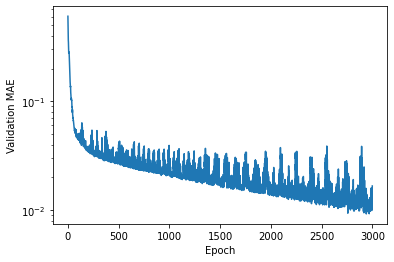

time: 297 ms (started: 2022-07-06 18:06:52 +00:00)


In [90]:
fig,ax = plt.subplots(1)
ax.plot(trainEuss.vaildation_data_mae)
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.yscale('log')
# plt.savefig('./Heston_without_wLSE_without_supervised_100k.eps', format='eps')

In [91]:
input_data = supervised_data['heston_input']
bs_pred = bs_price( "C", 
    input_data[:,2].reshape(-1,1), 
    input_data[:,1].reshape(-1,1), 
    input_data[:,3].reshape(-1,1) - input_data[:,0].reshape(-1,1), 
    input_data[:,10].reshape(-1,1)**0.5, 
    input_data[:,4].reshape(-1,1)
)
target = supervised_data['heston_analytical_sol']
prediction = trainEuss.net(input_data)


sol = torch.abs(target - prediction).cpu().detach().numpy()
sol.mean(), sol.var()

(0.016839047967878704, 0.00012581219133855578)

time: 5.6 ms (started: 2022-07-06 18:07:03 +00:00)


In [61]:
np.argmin(sol)

1924

time: 2.73 ms (started: 2022-07-06 16:25:46 +00:00)


In [271]:
size=5000

S_internals = torch.rand([size, 1]) * 3 
maturity_times = torch.rand([size, 1]) * 1
t_internals = torch.rand([size,1]) * maturity_times
strikes = torch.rand([size, 1]) * 1 
risk_free_rates = torch.rand([size, 1])*0.05
std_dev_of_stocks = torch.rand([size, 1])*0.25
nu_internals = (1. - torch.rand([size, 1])) * 2.
vol_vols = torch.rand([size, 1]) * 0.5
kappas = torch.rand([size, 1]) * 1
rhos = torch.rand([size, 1]) * 0.8
thetas = torch.rand([size, 1]) * 0.15
lamdas = torch.rand([size, 1]) * 0.
xvts = torch.cat(( t_internals , S_internals, strikes, maturity_times, risk_free_rates, std_dev_of_stocks), dim = 1 )
xvts_heston = torch.cat(( t_internals , S_internals, strikes, maturity_times, risk_free_rates, std_dev_of_stocks, nu_internals, vol_vols, kappas, rhos, thetas, lamdas), dim = 1 )

u0_terminal = bs_price( "C", strikes, S_internals, maturity_times - t_internals, std_dev_of_stocks, risk_free_rates)
mask = u0_terminal >= 0.

time: 16.5 ms (started: 2022-07-05 14:32:10 +00:00)


Text(0, 0.5, 'nn price via bs pde')

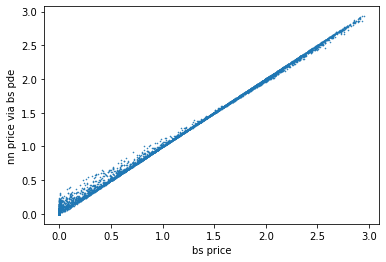

time: 243 ms (started: 2022-07-05 14:32:18 +00:00)


In [272]:
net_cpu = trainEuss.model.net.cpu()
net_cpu.eval()
plt.scatter(torch.flatten(u0_terminal[mask]).numpy(), torch.flatten(net_cpu(xvts_heston)[mask]).detach().numpy(), s=.3)
plt.xlabel('bs price')
plt.ylabel('nn price via bs pde')

In [273]:
np.mean(np.abs(torch.flatten(u0_terminal).numpy() - torch.flatten(net_cpu(xvts_heston)).detach().numpy()))

0.018940257

time: 56.6 ms (started: 2022-07-05 14:36:45 +00:00)


Text(0, 0.5, 'Heston')

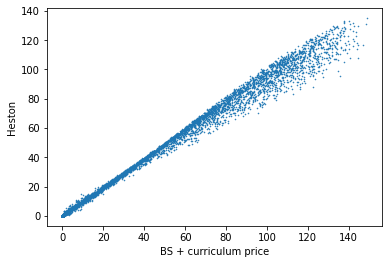

time: 291 ms (started: 2022-07-05 14:12:32 +00:00)


In [265]:
net_cpu2 = trainEuss2.model.net.cpu()
net_cpu2.eval()
plt.scatter(torch.flatten(u0_terminal[mask]).numpy() + torch.flatten(net_cpu2(xvts_heston)[mask]).detach().numpy(), torch.flatten(net_cpu(xvts_heston)[mask]).detach().numpy(), s=.3)
plt.xlabel('BS + curriculum price')
plt.ylabel('Heston')

## Testing on examples

In [274]:
df = pd.read_csv('heston_analytical_sol_partA.csv').drop(columns='Unnamed: 0')
df2 = pd.read_csv('heston_analytical_sol_partB.csv').drop(columns='Unnamed: 0')
df = df.append(df2)
df.reset_index(drop=True, inplace=True)

y = df['heston_analytical']
s = torch.tensor(df['stock_values'])
nu = torch.tensor(df['nu_values'])
t = torch.tensor(df['time_to_maturity'])

r = torch.tensor(df['risk_free_rate'])
q = torch.tensor(df['dividend'])
kappa = torch.tensor(df['kappa'])
theta = torch.tensor(df['theta'])
sigma = torch.tensor(df['sigma_vol_of_vol'])
rho = torch.tensor(df['rho_corr_vol_stock'])
strike = torch.ones(rho.shape[0])
size_test = len(df)
del df, df2

time: 56 ms (started: 2022-07-05 14:37:00 +00:00)


In [275]:
xvts_test = torch.cat(( 1 - t[:,None] , s[:,None], strike[:,None], torch.ones(size_test, 1), r[:,None], torch.ones(size_test, 1) * 0.25, nu[:,None], sigma[:,None], kappa[:,None], rho[:,None], theta[:,None], torch.zeros(size_test, 1)), dim = 1 )
xvts_test = torch.tensor(xvts_test, dtype=torch.float32)

time: 5.66 ms (started: 2022-07-05 14:37:05 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Text(0, 0.5, 'heston price via nn')

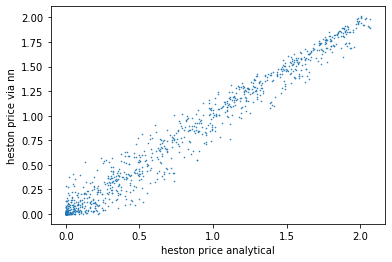

time: 221 ms (started: 2022-07-05 14:37:14 +00:00)


In [276]:
net_cpu = trainEuss.model.net.cpu()
net_cpu.eval()
plt.scatter(y.values, torch.flatten(net_cpu(xvts_test)).detach().numpy(), s=.3)
plt.xlabel('heston price analytical')
plt.ylabel('heston price via nn')

In [277]:
np.mean(np.abs(y.values - torch.flatten(net_cpu(xvts_test)).detach().numpy()))

0.07744803013812487

time: 21.5 ms (started: 2022-07-05 14:37:21 +00:00)


### Hessian Test

In [ ]:
# import numpy as np
# import torch, torchvision
# from torch.autograd import Variable, grad
# import torch.distributions as td
# import math
# from torch.optim import Adam
# import scipy.stats

# x_data = torch.randn(100)+0.0 # observed data (here sampled under H0)
# N = x_data.shape[0] # number of observations
# mu_null = torch.zeros(1)
# sigma_null_hat = Variable(torch.ones(1), requires_grad=True)

# def log_lik(mu, sigma):
#   return td.Normal(loc=mu, scale=sigma).log_prob(x_data).sum()

# # Find theta_null_hat by some gradient descent algorithm (in this case an closed-form expression would be trivial to obtain (see below)):
# opt = Adam([sigma_null_hat], lr=0.01)
# for epoch in range(2000):
#     opt.zero_grad() # reset gradient accumulator or optimizer
#     loss = - log_lik(mu_null, sigma_null_hat) # compute log likelihood with current value of sigma_null_hat  (= Forward pass)
#     loss.backward() # compute gradients (= Backward pass)
#     opt.step()      # update sigma_null_hat
    
# print(f'parameter fitted under null: sigma: {sigma_null_hat}, expected: {torch.sqrt((x_data**2).mean())}')
# #> parameter fitted under null: sigma: tensor([0.9260], requires_grad=True), expected: 0.9259940385818481

# theta_null_hat = (mu_null, sigma_null_hat)

# U = torch.tensor(torch.autograd.functional.jacobian(log_lik, theta_null_hat)) # Jacobian (= vector of partial derivatives of log likelihood w.r.t. the parameters (of the full/alternative model)) = score
# I = -torch.tensor(torch.autograd.functional.hessian(log_lik, theta_null_hat)) / N # estimate of the Fisher information matrix
# S = torch.t(U) @ torch.inverse(I) @ U / N # test statistic, often named "LM" (as in Lagrange multiplier), would be zero at the maximum likelihood estimate

# pval_score_test = 1 - scipy.stats.chi2(df = 1).cdf(S) # S asymptocially follows a chi^2 distribution with degrees of freedom equal to the number of parameters fixed under H0
# print(f'p-value Chi^2-based score test: {pval_score_test}')
# #> p-value Chi^2-based score test: 0.9203232752568568

# # comparison with Student's t-test:
# pval_t_test = scipy.stats.ttest_1samp(x_data, popmean = 0).pvalue
# print(f'p-value Student\'s t-test: {pval_t_test}')
# #> p-value Student's t-test: 0.9209265268946605


time: 3.25 ms (started: 2022-06-29 14:07:09 +00:00)


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cpu.empty_cache()

AttributeError: ignored

time: 268 ms (started: 2022-06-29 14:07:09 +00:00)


In [ ]:
# nseed = 123
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# np.random.seed(seed)
# random.seed(seed)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

# eqLossFn= 'calculateLoss'
# sample_method= "U"
# lr = 0.001
# net = EuropeanOptionNet( NL = 3 , NN = 30 )
# net.to(torch.device("cuda:0")) 
# ## providing sampler with net so it can accept/reject based on net and other criterions
# bsequation = EuropeanBlackScholesSingleStock(net)
# bsequation.xbreaks = np.linspace(0, bsequation.MAX_X, 2).tolist()
# bsequation.tbreaks = np.linspace(0, bsequation.T, 2).tolist()
# trainEuss = TrainEuropeanBlackScholesSingleStock( net , bsequation, BATCH_SIZE = 2**8 , debug = True )
# trainEuss.hook_interval = 500
# trainEuss.use_early_stop = True
# trainEuss.early_stop_patience = 1500
# trainEuss.validation_sample = bsequation.sample(sample_method_X="U", size=2**6)
# trainEuss.train( epoch = 4000 , lr = lr, eqLossFn = eqLossFn , sample_method_X = sample_method)

In [ ]:
# [*to_cpu_detach(stratum_losses_L2_validation),
#                                                 *to_cpu_detach(stratum_losses_ABS_validation),
#                                                 *to_cpu_detach(stratum_losses_Huber_validation)]

In [ ]:
# df = trainEuss.history_surfaces_hooks[trainEuss.history_surfaces_hooks.Epoch == max(trainEuss.history_surfaces_hooks.Epoch)]
# fig = px.scatter_3d(df, x='Time', y='S1', z='Result',color='Sample', width=500, height=400)
# fig.show()

In [ ]:
# save_model_train(lr, net,  eqLossFn, sample_method, trainEuss, "EuCallSs" )

In [ ]:
# testmodel = AmericanOptionNet(NL = 3, NN = 30)
# print(os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals"))
# testmodel.load_state_dict(torch.load(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/AmCallSs_20220504153012_calculateLoss_U_5558_3_30"))
# testmodel.forward(bsequation.sample("U", 2**4)[0].cpu().detach())

In [ ]:

    # def sample_stratified(self , sample_method_X = "U", size = 2**8, to_cpu = False ):
    #   if self.xbreaks is None and self.tbreaks is None:
    #     return self.sample(sample_method_X, size, to_cpu)
    #   internal_strata_xts = []
    #   terminal_strata_xts = []
    #   initial_strata_xts = []
    #   nonzero_strata_xts = []
    #   if sample_method_X in ["U","UE3"]:
    #       range_multiplier = 3.0 if sample_method_X == "UE3" else 1.0
    #       xbreaks_used = self.xbreaks[:] if self.xbreaks is not None else [0,range_multiplier*self.MAX_X]
    #       tbreaks_used = self.tbreaks[:] if self.tbreaks is not None else [0,self.T]
    #       if xbreaks_used[-1] < range_multiplier*self.MAX_X:
    #         xbreaks_used.append(range_multiplier*self.MAX_X)
    #       while xbreaks_used[0] < 0.0:
    #         xbreaks_used.pop(0)
    #       if not xbreaks_used:
    #         xbreaks_used = [0,range_multiplier*self.MAX_X]
    #       if xbreaks_used[0] > 0.0:            
    #         xbreaks_used.insert(0, 0.0)
    #       if tbreaks_used[-1] < self.T:
    #         tbreaks_used.append(self.T)
    #       xbreaks_range = xbreaks_used[-1]-xbreaks_used[0]
    #       tbreaks_range = tbreaks_used[-1]-tbreaks_used[0]
    #       total_strat_processed = 0
    #       for stratum_x_count in range(len(xbreaks_used)-1):
    #         num_samples_in_stratum = 0
    #         if len(xbreaks_used) > 2:  # x division takes priority so assign it if there is no T division
    #           range_ratio_x_stratum = (xbreaks_used[stratum_x_count+1]-xbreaks_used[stratum_x_count])/xbreaks_range
    #           num_samples_in_stratum = math.ceil(range_ratio_x_stratum*size)
    #         for stratum_t_count in range(len(self.tbreaks)-1):
    #           if num_samples_in_stratum == 0: # there is only a T division, so use it
    #             range_ratio_t_stratum = (tbreaks_used[stratum_t_count+1]-tbreaks_used[stratum_t_count])/tbreaks_range
    #             num_samples_in_stratum = math.ceil(range_ratio_t_stratum*size)
    #           else:
    #             # there is both an X and a T division, assign the number of samples uniformly, assuming same scale of X and T
    #             stratum_coverage_on_unit_square = \
    #               ((xbreaks_used[stratum_x_count+1]-xbreaks_used[stratum_x_count])/xbreaks_range)*\
    #               ((tbreaks_used[stratum_t_count+1]-tbreaks_used[stratum_t_count])/tbreaks_range)
    #             num_samples_in_stratum = math.ceil(stratum_coverage_on_unit_square * size)
    #           ### internal samples
    #           internal_stratum_t_sample = self.to_device(tbreaks_used[stratum_t_count] + torch.rand([num_samples_in_stratum,1])*(tbreaks_used[stratum_t_count+1]-tbreaks_used[stratum_t_count]), to_cpu)
    #           internal_stratum_x_sample = self.to_device(xbreaks_used[stratum_x_count] + torch.rand([num_samples_in_stratum,1])*(xbreaks_used[stratum_x_count+1]-xbreaks_used[stratum_x_count]), to_cpu)
    #           internal_stratum_xt = torch.cat(( internal_stratum_t_sample , internal_stratum_x_sample) , dim = 1 )
    #           if internal_stratum_xt.numel()<1:
    #             # pdb.set_trace()
    #             pass
    #           if not internal_strata_xts: #.numel()<1:
    #             internal_strata_xts = [ internal_stratum_xt ] # internal_stratum_xt[None,:,:]
    #           else:
    #             internal_strata_xts.append(internal_stratum_xt)  # torch.vstack((internal_strata_xts,internal_stratum_xt[None,:,: ]))

    #           ### Terminal time samples
    #           terminal_stratum_x_sample = xbreaks_used[stratum_x_count] + torch.rand([num_samples_in_stratum,1])*(xbreaks_used[stratum_x_count+1]-xbreaks_used[stratum_x_count])
    #           terminal_stratum_xt = self.to_device(torch.cat( ( torch.zeros(num_samples_in_stratum, 1) + self.T , terminal_stratum_x_sample ) , dim = 1 ),to_cpu)

    #           if not terminal_strata_xts:
    #             terminal_strata_xts = [ terminal_stratum_xt ] # terminal_stratum_xt[None,:,:]
    #           else:
    #             terminal_strata_xts.append(terminal_stratum_xt) # torch.vstack((terminal_strata_xts,terminal_stratum_xt[None,:,: ]))

    #           ### initial time samples
    #           # x_initial = torch.cat( ( torch.zeros(size, 1), -self.MAX_X*range_multiplier*torch.rand([size, 1])+self.MAX_X*range_multiplier ) , dim = 1 ).cuda()
    #           ### initial time samples
    #           initial_stratum_xt = self.to_device(torch.cat( ( torch.zeros(num_samples_in_stratum, 1), self.K*torch.ones( num_samples_in_stratum, 1)) , dim = 1 ),to_cpu)
    #           if not initial_strata_xts: #.numel()<1:
    #             initial_strata_xts = [initial_stratum_xt] # initial_stratum_xt[None,:,:]
    #           else:
    #             initial_strata_xts.append(initial_stratum_xt) # torch.vstack((initial_strata_xts,initial_stratum_xt[None,:,: ]))

    #           ### non-zero value samples
    #           stratum_mapped_stock_space = None
    #           if self.is_call:
    #             stratum_mapped_stock_space = self.K*(1.0/xbreaks_used[-1])* np.array([ xbreaks_used[stratum_x_count], xbreaks_used[stratum_x_count+1]])
    #           else:
    #             stratum_mapped_stock_space = self.K + self.K*(1.0/xbreaks_used[-1])*np.array([ xbreaks_used[stratum_x_count], xbreaks_used[stratum_x_count+1]])              
    #           nonzero_stratum_x_sample = stratum_mapped_stock_space[0] + torch.rand([num_samples_in_stratum, 1])*(stratum_mapped_stock_space[1]-stratum_mapped_stock_space[0])
    #           nonzero_stratum_xt = self.to_device(torch.cat( ( torch.rand([num_samples_in_stratum,1])*self.T, nonzero_stratum_x_sample ) , dim = 1 ),to_cpu)
    #           compare = self.net(nonzero_stratum_xt) 
    #           mask = compare < 0
    #           nonzero_stratum_xt = nonzero_stratum_xt[mask.reshape(-1),:]
    #           if not nonzero_strata_xts: #.numel()<1:
    #             nonzero_strata_xts = [nonzero_stratum_xt] #nonzero_stratum_xt[None,:,:]
    #           else:
    #             # pdb.set_trace()
    #             nonzero_strata_xts.append(nonzero_stratum_xt) # torch.vstack((nonzero_strata_xts,nonzero_stratum_xt[None,:,: ]))
    #           total_strat_processed += 1 
    #       return internal_strata_xts , terminal_strata_xts , initial_strata_xts, nonzero_strata_xts
    #   raise ValueError(f"{sample_method_X} is not a supported sampling method")